In [2]:
# Импортируем необходимые библиотеки
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
# Устанавливаем случайное зерно для воспроизводимости результатов
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
# Создаем класс для отслеживания метрик
class MetricTracker:
    def __init__(self):
        self.metrics = defaultdict(list)

    def update(self, metrics):
        for key, value in metrics.items():
            self.metrics[key].append(value)

# Создаем коллбэк для сохранения метрик
class MetricsCallback(pl.Callback):
    def __init__(self, tracker):
        self.tracker = tracker

    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        self.tracker.update({
            'train_loss': metrics['train_loss'].item(),
            'train_acc': metrics['train_acc'].item(),
            'val_loss': metrics['val_loss'].item(),
            'val_acc': metrics['val_acc'].item()
        })

In [5]:
# Определяем преобразования данных
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),  # AlexNet требует входные изображения 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

In [6]:
# Функция подготовки данных
def prepare_data():
    # Загрузка CIFAR100
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)

    # Разделение тренировочного набора на train и validation
    train_size = int(0.8 * len(trainset))
    val_size = len(trainset) - train_size
    trainset, valset = random_split(trainset, [train_size, val_size])

    return trainset, valset, testset

In [7]:
# Определяем модуль данных PyTorch Lightning
class CIFAR100DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=128):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.trainset, self.valset, self.testset = prepare_data()

    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size,
                        shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=self.batch_size,
                        shuffle=False, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size,
                        shuffle=False, num_workers=4)

In [8]:
# Реализация архитектуры AlexNet
class AlexNet(pl.LightningModule):
    def __init__(self, num_classes=100):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                             mode='min',
                                                             factor=0.1,
                                                             patience=5,
                                                             verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

In [9]:
# Функция для оценки точности по классам
def evaluate_per_class(model, test_loader, num_classes=100):
    model.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    # Вычисляем точность для каждого класса
    class_accuracy = {}
    for i in range(num_classes):
        if class_total[i] > 0:
            accuracy = class_correct[i] / class_total[i]
            class_accuracy[i] = accuracy

    return class_accuracy

In [10]:
# Инициализируем трекер метрик
tracker = MetricTracker()

# Запускаем обучение
data_module = CIFAR100DataModule()
data_module.setup()
model = AlexNet()

# Настройка callback'ов
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./checkpoints',
    filename='alexnet-cifar100-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

metrics_callback = MetricsCallback(tracker)

# Инициализация тренера
trainer = pl.Trainer(
    max_epochs=15,
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, metrics_callback],
    log_every_n_steps=50,
)

# Обучение модели
trainer.fit(model, data_module)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | features   | Sequential | 2.5 M  | train
1 | classifier | Sequential | 54.9 M | train
--------------------------------------------------
57.4 M    Trainable params
0         Non-trainable params
57.4 M    Total params
229.654   Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


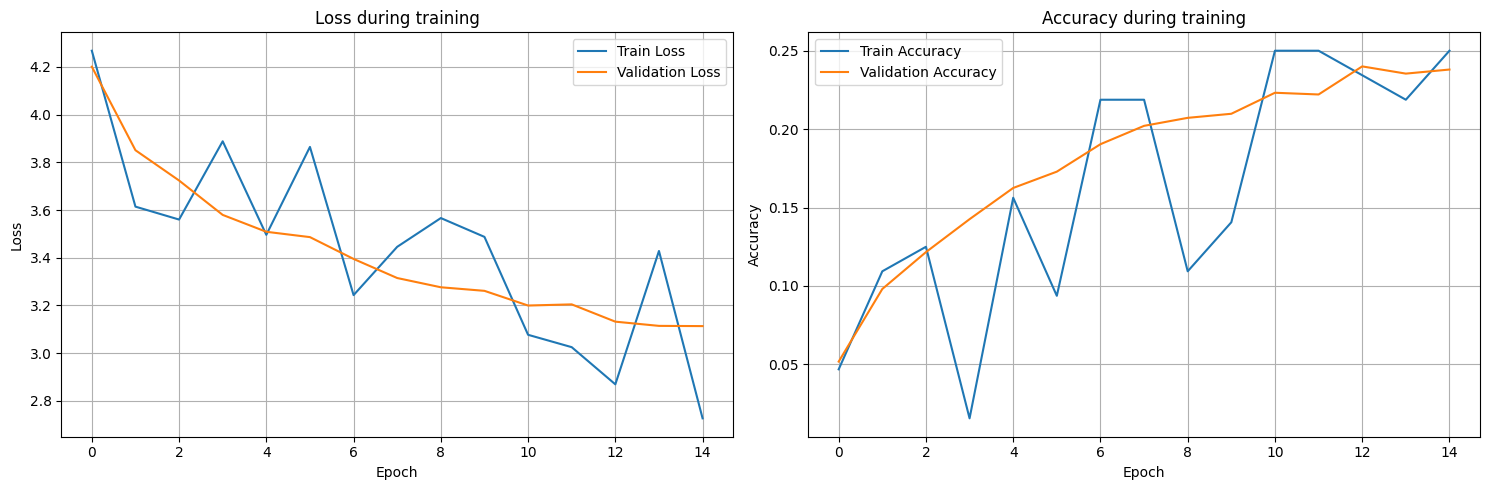

Final metrics:
Train Loss: 2.7269
Validation Loss: 3.1135
Train Accuracy: 0.2500
Validation Accuracy: 0.2380


In [11]:
# Построение графиков метрик
plt.figure(figsize=(15, 5))

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(tracker.metrics['train_loss'], label='Train Loss')
plt.plot(tracker.metrics['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График точности
plt.subplot(1, 2, 2)
plt.plot(tracker.metrics['train_acc'], label='Train Accuracy')
plt.plot(tracker.metrics['val_acc'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Вывод финальных метрик
print("Final metrics:")
print(f"Train Loss: {tracker.metrics['train_loss'][-1]:.4f}")
print(f"Validation Loss: {tracker.metrics['val_loss'][-1]:.4f}")
print(f"Train Accuracy: {tracker.metrics['train_acc'][-1]:.4f}")
print(f"Validation Accuracy: {tracker.metrics['val_acc'][-1]:.4f}")

In [14]:
# Оценка на тестовом наборе
test_results = trainer.test(model, datamodule=data_module)

print("\nTest set metrics:")
print(f"Test Loss: {test_results[0]['test_loss']:.4f}")
print(f"Test Accuracy: {test_results[0]['test_acc']:.4f}")

# Определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

def evaluate_per_class(model, test_loader, num_classes=100, device=device):
    model.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    # Вычисляем точность для каждого класса
    class_accuracy = {}
    for i in range(num_classes):
        if class_total[i] > 0:
            accuracy = class_correct[i] / class_total[i]
            class_accuracy[i] = accuracy

    return class_accuracy

# Получаем точность по классам с указанием устройства
class_accuracy = evaluate_per_class(model, data_module.test_dataloader(), device=device)

# Выводим топ-5 лучших и худших классов по точности
sorted_classes = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)

print("\nTop 5 best performing classes:")
for class_idx, acc in sorted_classes[:5]:
    print(f"Class {class_idx}: {acc:.4f}")

print("\nTop 5 worst performing classes:")
for class_idx, acc in sorted_classes[-5:]:
    print(f"Class {class_idx}: {acc:.4f}")

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.26910001039505005    │
│         test_loss         │    2.9731671810150146     │
└───────────────────────────┴───────────────────────────┘


Test set metrics:
Test Loss: 2.9732
Test Accuracy: 0.2691

Top 5 best performing classes:
Class 68: 0.7400
Class 60: 0.7100
Class 20: 0.7000
Class 52: 0.6700
Class 94: 0.6200

Top 5 worst performing classes:
Class 50: 0.0300
Class 72: 0.0300
Class 80: 0.0300
Class 55: 0.0200
Class 78: 0.0200


## Выводы

- видим снижения лосса на графике
- точность недостаточно высокая по некоторым классам, нужно больше времени для обучения
